Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [454]:
import numpy as np
df

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,8/27/2019,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,8/27/2019,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [456]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [457]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataframe has 59 columns.
There are 55 columns that have missing values.


,Missing Values,% of Total Values
Queso,421,100.0
Zucchini,420,99.8
Carrots,420,99.8
Lobster,420,99.8
Ham,419,99.5
Sushi,419,99.5
Bacon,418,99.3
Corn,418,99.3
Mushroom,418,99.3
Taquito,417,99.0


In [458]:
# So many missing values. Only the columns with 50% or less null values are to be
# included in the new df, including Date, Great, Burrito, and Tortilla (0 missing).
df = df[['Date', 'Great', 'Burrito', 'Tortilla', 'Synergy', 'Uniformity', 'Wrap',
         'Hunger', 'Fillings', 'Cost', 'Meat:filling', 'Meat', 'Temp', 'Salsa', 
         'Length', 'Volume', 'Circum']].copy()
df

,Date,Great,Burrito,Tortilla,Synergy,Uniformity,Wrap,Hunger,Fillings,Cost,Meat:filling,Meat,Temp,Salsa,Length,Volume,Circum
0,1/18/2016,False,California,3.0,4.0,4.0,4.0,3.0,3.5,6.49,4.0,3.0,5.0,4.0,NaN,NaN,NaN
1,1/24/2016,False,California,2.0,2.5,4.0,5.0,3.5,2.5,5.45,2.0,2.5,3.5,3.5,NaN,NaN,NaN
2,1/24/2016,False,Carnitas,3.0,3.0,4.0,5.0,1.5,3.0,4.85,4.5,2.5,2.0,3.0,NaN,NaN,NaN
3,1/24/2016,False,Asada,3.0,4.0,5.0,5.0,2.0,3.0,5.25,4.0,3.5,2.0,4.0,NaN,NaN,NaN
4,1/27/2016,True,California,4.0,4.5,5.0,4.0,4.0,3.5,6.59,4.5,4.0,5.0,2.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,8/27/2019,False,Other,5.0,2.0,4.0,5.0,1.0,NaN,6.00,4.0,3.5,4.0,2.0,17.0,0.57,20.5
419,8/27/2019,True,Other,4.0,4.0,4.0,3.0,4.0,3.5,6.00,4.0,NaN,5.0,5.0,19.0,1.02,26.0
420,8/27/2019,False,California,4.0,4.0,2.0,4.5,3.0,3.7,7.90,3.0,4.0,4.0,3.5,20.0,0.77,22.0
421,8/27/2019,True,Other,5.0,5.0,2.0,2.0,3.0,5.0,7.90,5.0,5.0,2.0,5.0,22.5,1.07,24.5


In [0]:
#Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
train = df[(df['Date'] < '2016-12-31 23:59:59')]

In [0]:
val = df[(df['Date'] > '2017-01-01 00:00:00') & (df['Date'] <= '2017-12-31 23:59:59')]

In [0]:
test = df[(df['Date'] > '2018-01-01 00:00:00') & (df['Date'] <= '2018-12-31 23:59:59')]

In [464]:
train.shape, val.shape, test.shape

((298, 17), (85, 17), (27, 17))

In [0]:
#Begin with baselines for classification.

In [466]:
target = "Great"
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred_train = [majority_class]*len(y_train)

In [468]:
from sklearn.metrics import  accuracy_score

accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [469]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [470]:
train.describe()

,Tortilla,Synergy,Uniformity,Wrap,Hunger,Fillings,Cost,Meat:filling,Meat,Temp,Salsa,Length,Volume,Circum
count,298.000000,296.000000,296.000000,296.000000,297.000000,297.000000,292.000000,292.000000,288.000000,283.000000,278.000000,175.000000,174.000000,174.000000
mean,3.472315,3.540203,3.395946,3.955068,3.445286,3.519024,6.896781,3.528870,3.551215,3.706360,3.324640,19.829886,0.770920,22.042241
std,0.797606,0.922426,1.089044,1.167341,0.852150,0.850348,1.211412,1.040457,0.869483,0.991897,0.971226,2.081275,0.137833,1.685043
min,1.400000,1.000000,1.000000,0.000000,0.500000,1.000000,2.990000,0.500000,1.000000,1.000000,0.000000,15.000000,0.400000,17.000000
25%,3.000000,3.000000,2.500000,3.500000,3.000000,3.000000,6.250000,3.000000,3.000000,3.000000,2.500000,18.500000,0.662500,21.000000
50%,3.500000,3.750000,3.500000,4.000000,3.500000,3.500000,6.850000,4.000000,3.500000,4.000000,3.500000,19.500000,0.750000,22.000000
75%,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,7.500000,4.000000,4.000000,4.500000,4.000000,21.000000,0.870000,23.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,11.950000,5.000000,5.000000,5.000000,5.000000,26.000000,1.240000,27.000000


In [471]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Cost', 'Volume', 'Fillings']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.39817923,  0.57105777,  0.26321334,  0.25607833,  0.03413256,
        0.41895463,  0.56382587,  0.54104749, -0.08694018,  0.39651781,
        0.50538112,  0.40439652,  0.59502381,  0.40215422,  0.57232951,
        0.58538551,  0.48968428,  0.57885774,  0.56398984,  0.58954647,
        0.58954647,  0.26327945,  0.24688233,  0.58298763,  0.72878033,
        0.55590178,  0.68878363,  0.37090299,  0.54103388,  0.40698919,
        0.48415366,  0.23478476,  0.23557286,  0.242331  ,  0.34985408,
        0.34985408,  0.22214067,  0.39231595,  0.49051253,  0.44566446,
        0.26722383,  0.47791716,  0.20236741,  0.53731148,  0.38967088,
        0.36804483, -0.22759159,  0.07114564,  0.58743317, -0.11660081,
        0.07773981,  0.40244702,  0.58950679,  0.6043747 ,  0.39904348,
        0.25051692,  0.2192963 ,  0.39329088,  0.21095095,  0.39734577,
       -0.13069779,  0.4172352 ,  0.23427453,  0.40727736,  0.5832895 ,
        0.59950903,  0.41280345,  0.88676925,  0.24183098,  0.41

In [472]:
features

['Cost', 'Volume', 'Fillings']

In [473]:
pd.Series(linear_reg.coef_, features)

Cost        0.016397
Volume     -0.135163
Fillings    0.340351
dtype: float64

In [474]:
test_case = [[6.85, 0.75, 3.5]] # 50% std Cost, Volume, Fillings
linear_reg.predict(test_case)

array([0.40498176])

In [0]:
#Use scikit-learn for logistic regression.

In [476]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))
# same thing
# y_pred = log_reg.predict(X_val_imputed)
# print('Validation Accuracy', accuracy_score(y_pred, y_val))

Validation Accuracy 0.8470588235294118


In [477]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([False,  True, False, False, False, False,  True,  True, False,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True, False,
        True, False,  True,  True])

In [478]:
log_reg.predict(test_case)

array([False])

In [479]:
log_reg.predict_proba(test_case)[0]

array([0.66080286, 0.33919714])

In [480]:
# What's the math?
log_reg.coef_

array([[ 0.12243296, -0.21696359,  2.13602033]])

In [481]:
log_reg.intercept_

array([-8.8188883])

In [0]:
# The logistic sigmoid 'squishing' function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [483]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.33919714]])

In [484]:
1 - sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.66080286]])

In [485]:
features = ['Burrito', 'Tortilla', 'Synergy', 'Uniformity', 'Wrap',
         'Hunger', 'Fillings', 'Cost', 'Meat:filling', 'Meat', 'Temp', 'Salsa', 
         'Length', 'Volume', 'Circum']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((298, 15), (85, 15))

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [487]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 19), (85, 19))

In [488]:
X_val_enc.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Tortilla,Synergy,Uniformity,Wrap,Hunger,Fillings,Cost,Meat:filling,Meat,Temp,Salsa,Length,Volume,Circum
301,1,0,0,0,0,4.0,3.50,5.0,4.5,NaN,3.5,6.60,3.5,4.0,4.5,1.5,23.0,0.77,20.5
302,0,0,0,1,0,4.0,3.75,4.6,5.0,NaN,4.0,6.60,NaN,NaN,2.0,4.2,20.5,0.75,21.5
303,0,0,0,1,0,3.0,4.20,4.0,5.0,3.9,3.0,8.50,3.7,4.1,4.5,4.3,21.0,0.74,21.0
304,0,0,0,1,0,3.5,3.80,4.5,4.8,4.0,3.0,7.90,4.0,4.0,4.0,4.0,20.5,0.72,21.0
305,0,0,0,1,0,2.5,2.00,3.0,4.0,3.5,2.5,4.99,3.0,3.0,4.5,2.0,18.5,0.75,22.5


In [489]:
imputer = SimpleImputer(strategy='most_frequent')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((298, 19), (85, 19))

In [0]:
X_train_imp = pd.DataFrame(X_train_imp, columns = X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns = X_val_enc.columns)

In [491]:
X_val_imp

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Tortilla,Synergy,Uniformity,Wrap,Hunger,Fillings,Cost,Meat:filling,Meat,Temp,Salsa,Length,Volume,Circum
0,1.0,0.0,0.0,0.0,0.0,4.0,3.50,5.0,4.5,4.0,3.5,6.60,3.5,4.0,4.5,1.5,23.0,0.77,20.5
1,0.0,0.0,0.0,1.0,0.0,4.0,3.75,4.6,5.0,4.0,4.0,6.60,4.0,4.0,2.0,4.2,20.5,0.75,21.5
2,0.0,0.0,0.0,1.0,0.0,3.0,4.20,4.0,5.0,3.9,3.0,8.50,3.7,4.1,4.5,4.3,21.0,0.74,21.0
3,0.0,0.0,0.0,1.0,0.0,3.5,3.80,4.5,4.8,4.0,3.0,7.90,4.0,4.0,4.0,4.0,20.5,0.72,21.0
4,0.0,0.0,0.0,1.0,0.0,2.5,2.00,3.0,4.0,3.5,2.5,4.99,3.0,3.0,4.5,2.0,18.5,0.75,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1.0,0.0,0.0,0.0,0.0,3.0,4.00,3.5,3.0,3.5,3.8,6.85,4.0,3.8,4.5,3.5,22.5,0.91,22.5
81,1.0,0.0,0.0,0.0,0.0,3.0,4.00,3.0,3.5,3.5,4.0,6.85,4.5,4.0,4.5,4.0,22.2,0.89,22.5
82,0.0,0.0,0.0,1.0,0.0,2.0,4.00,4.5,2.0,3.5,3.5,11.50,3.0,4.0,2.0,3.5,15.0,0.75,25.0
83,1.0,0.0,0.0,0.0,0.0,4.0,4.30,4.0,4.5,4.0,4.0,7.89,3.0,4.0,3.0,3.5,19.0,0.80,23.0


In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val_enc.columns)

In [494]:
X_train_sc.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Tortilla,Synergy,Uniformity,Wrap,Hunger,Fillings,Cost,Meat:filling,Meat,Temp,Salsa,Length,Volume,Circum
0,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-0.593162,0.497215,0.553163,0.032561,-0.526123,-0.024338,-0.327984,0.448071,-0.660685,1.322453,0.741728,0.062729,-0.584693,-0.019208
1,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-1.849023,-1.135813,0.553163,0.891239,0.062187,-1.203659,-1.194259,-1.493126,-1.244045,-0.228679,0.209755,0.062729,-0.584693,-0.019208
2,-0.809664,4.503967,-0.364801,-0.764922,-0.27534,-0.593162,-0.591471,0.553163,0.891239,-2.291054,-0.613999,-1.694033,0.933371,-1.244045,-1.779812,-0.322219,0.062729,-0.584693,-0.019208
3,-0.809664,-0.222027,2.741220,-0.764922,-0.27534,-0.593162,0.497215,1.475102,0.891239,-1.702744,-0.613999,-1.360851,0.448071,-0.077325,-1.779812,0.741728,0.062729,-0.584693,-0.019208
4,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,0.662698,1.041558,1.475102,0.032561,0.650498,-0.024338,-0.244688,0.933371,0.506036,1.322453,-0.854192,0.062729,-0.584693,-0.019208


In [495]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
# Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [497]:
print(f'Validaton score: {model.score(X_val_sc, y_val)}')

Validaton score: 0.8352941176470589


In [0]:
# Plot coefficients:

In [499]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Burrito_California     0.141354
Burrito_Carnitas       0.027733
Burrito_Asada         -0.004700
Burrito_Other         -0.093714
Burrito_Surf & Turf   -0.110426
Tortilla               0.320138
Synergy                0.660387
Uniformity             0.189291
Wrap                   0.069356
Hunger                 0.111037
Fillings               0.578029
Cost                   0.236317
Meat:filling           0.501927
Meat                   0.595314
Temp                   0.274739
Salsa                  0.249734
Length                 0.075967
Volume                -0.041393
Circum                 0.014603
dtype: float64

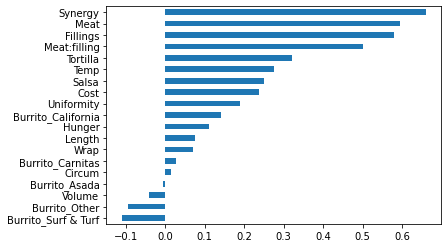

In [500]:
coefs.sort_values().plot.barh();

In [0]:
# Get your model's test accuracy. (One time, at the end.)

In [502]:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imp)
X_test_scaled

array([[ 1.23508045e+00, -2.22026518e-01, -3.64801107e-01,
        -7.64922469e-01, -2.75340288e-01,  6.62698293e-01,
         4.97215206e-01, -3.68775591e-01,  8.91239266e-01,
         6.50497505e-01,  1.74464275e+00,  3.05063532e-01,
         1.41866991e+00,  5.06035661e-01,  1.32245347e+00,
        -3.22218671e-01,  6.27285541e-02, -5.84693353e-01,
        -1.92082660e-02],
       [-8.09663853e-01, -2.22026518e-01, -3.64801107e-01,
         1.30732204e+00, -2.75340288e-01, -5.93162383e-01,
        -5.91470550e-01, -2.21265355e+00,  3.25606327e-02,
        -5.26123172e-01, -1.79331941e+00, -2.24378505e+00,
         4.48071308e-01, -1.82740537e+00,  1.32245347e+00,
         7.41727744e-01,  6.27285541e-02, -5.84693353e-01,
        -1.92082660e-02],
       [ 1.23508045e+00, -2.22026518e-01, -3.64801107e-01,
        -7.64922469e-01, -2.75340288e-01,  1.91855897e+00,
         1.58590096e+00,  1.47510236e+00,  8.91239266e-01,
         1.82711818e+00,  1.74464275e+00,  9.68242694e-02,
    

In [503]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ True, False,  True, False, False,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False,  True, False,  True,  True, False, False,  True])

In [504]:
submission = test[['Great']].copy()
submission

,Great
386,False
387,False
388,True
389,False
390,True
391,True
392,True
393,False
394,True
395,False


In [505]:
model = LogisticRegressionCV()
model.fit(X_test_scaled, submission)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [506]:
print(f'Test score: {model.score(X_test_scaled, submission)}')

Test score: 0.8888888888888888
